In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# Read the CSV file
data_path = '../data/ninja_pv_48.1495_11.5700_corrected.csv'
df_pv = pd.read_csv(data_path, skiprows=3, sep=',', parse_dates=["time"], index_col="time")

In [3]:
df_pv.head()

,local_time,electricity,irradiance_direct,irradiance_diffuse,temperature
time,,,,,
2019-01-01 00:00:00,2019-01-01 01:00,0.0,0.0,0.0,0.912
2019-01-01 01:00:00,2019-01-01 02:00,0.0,0.0,0.0,0.864
2019-01-01 02:00:00,2019-01-01 03:00,0.0,0.0,0.0,0.833
2019-01-01 03:00:00,2019-01-01 04:00,0.0,0.0,0.0,0.793
2019-01-01 04:00:00,2019-01-01 05:00,0.0,0.0,0.0,0.630


In [4]:
# Drop local_time column
df_pv = df_pv.drop(columns=["local_time"])

In [5]:
df_pv.shape

(8760, 4)

In [6]:
df_pv.describe()

,electricity,irradiance_direct,irradiance_diffuse,temperature
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.464890,0.112616,0.055560,8.735466
std,0.701744,0.214761,0.076687,7.878425
min,0.000000,-0.000000,0.000000,-9.897000
25%,0.000000,0.000000,0.000000,2.514000
50%,0.002000,0.000000,0.005000,8.306000
75%,0.762250,0.101000,0.091000,14.835750
max,2.610000,0.932000,0.355000,31.880000


In [7]:
# Rename the key column
df_pv.rename(columns={"electricity": "pv_output_kw"}, inplace=True)

# Extract time-based features
df_pv["hour"] = df_pv.index.hour
df_pv["month"] = df_pv.index.month
df_pv["season"] = df_pv["month"] % 12 // 3 + 1
df_pv["season"] = df_pv["season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

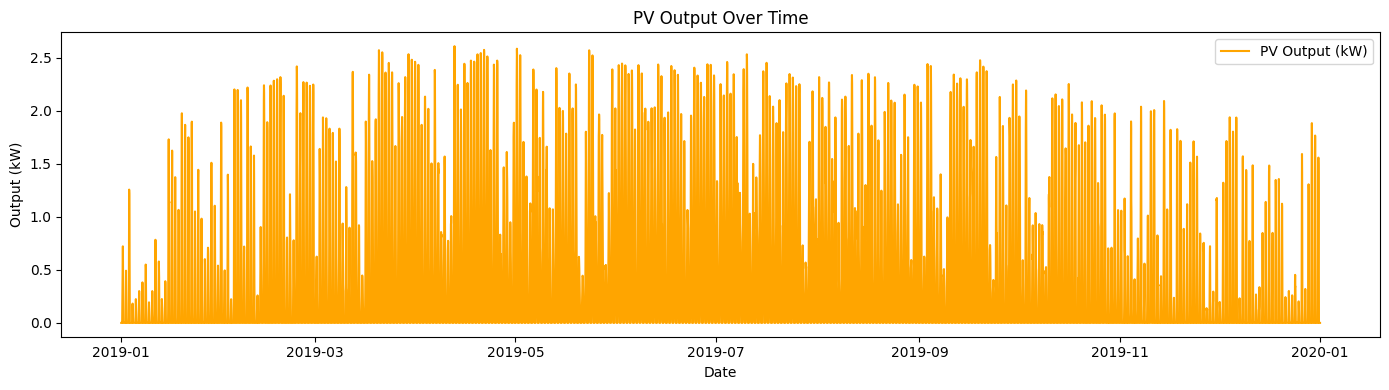

In [8]:
# 1. PV Output Over Time
plt.figure(figsize=(14, 4))
plt.plot(df_pv.index, df_pv["pv_output_kw"], color="orange", label="PV Output (kW)")
plt.title("PV Output Over Time")
plt.xlabel("Date")
plt.ylabel("Output (kW)")
plt.tight_layout()
plt.legend()
plt.show()

- Zero output at night and during winter months with low sun elevation.
- A seasonal wave pattern with higher production mid-year, aligning with longer daylight hours in spring and summer.

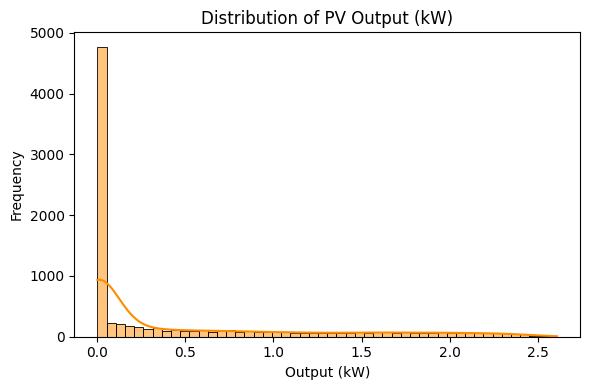

In [9]:
# 2. Distribution of PV Output
plt.figure(figsize=(6, 4))
sns.histplot(df_pv["pv_output_kw"], bins=50, kde=True, color="darkorange")
plt.title("Distribution of PV Output (kW)")
plt.xlabel("Output (kW)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

- A large spike at 0 kW, representing night or cloudy conditions.
- A right-skewed distribution, typical for PV output, since high generation only occurs during clear-sky midday periods.

/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_86119/2003407142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pv, x="season", y="pv_output_kw", palette="YlOrBr")


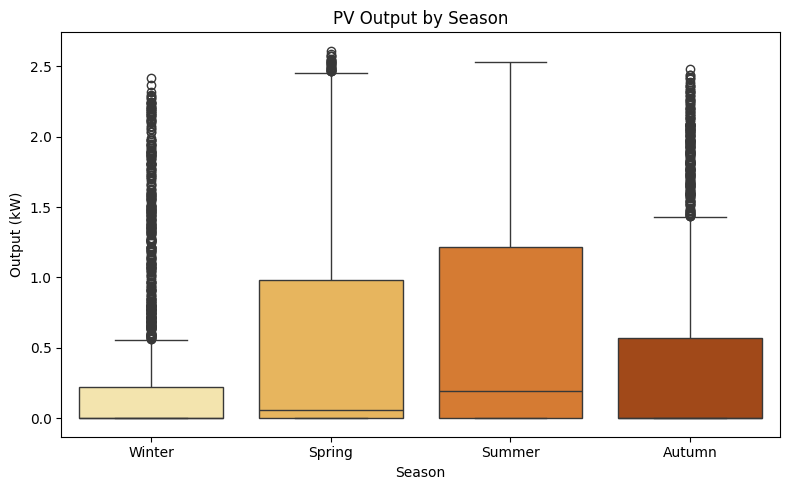

In [10]:
# 3. Boxplot by Season
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_pv, x="season", y="pv_output_kw", palette="YlOrBr")
plt.title("PV Output by Season")
plt.xlabel("Season")
plt.ylabel("Output (kW)")
plt.tight_layout()
plt.show()

- Summer shows the highest median and upper quartile PV generation.
- Winter has the lowest and most compressed output range.
- Spring and Autumn fall in between, with some variability depending on local cloudiness.

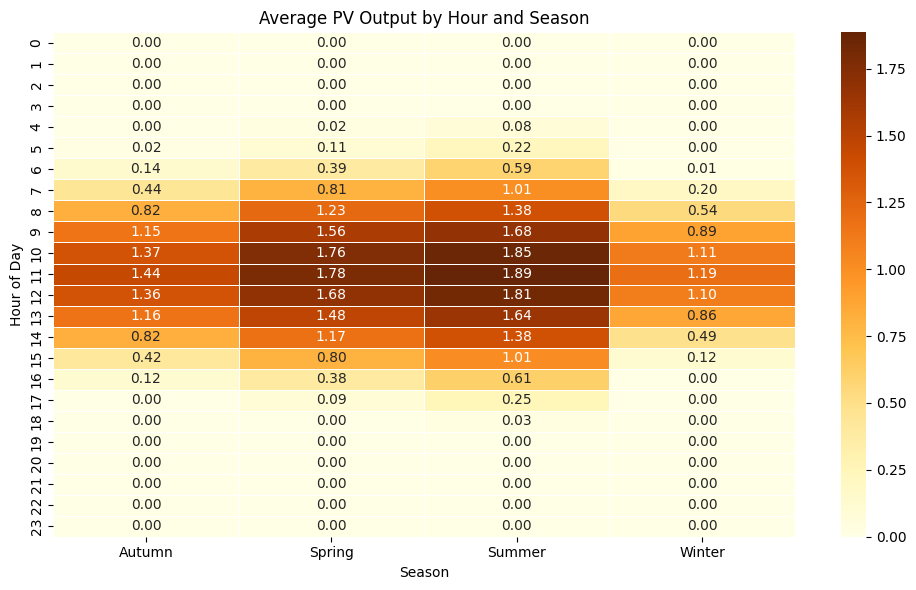

In [11]:
# 4. Heatmap of Hourly Pattern by Season
pivot = df_pv.pivot_table(index="hour", columns="season", values="pv_output_kw", aggfunc="mean")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="YlOrBr", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average PV Output by Hour and Season")
plt.xlabel("Season")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


- Peak output occurs between 11:00–14:00 in all seasons.
- In summer, generation starts earlier and extends later due to longer daylight hours.
- Winter shows a narrow generation window (shorter days) and lower overall values.

In [12]:
# 5. Summary Statistics and Missing Values
print("\nSummary Statistics:")
print(df_pv["pv_output_kw"].describe())


Summary Statistics:
count    8760.000000
mean        0.464890
std         0.701744
min         0.000000
25%         0.000000
50%         0.002000
75%         0.762250
max         2.610000
Name: pv_output_kw, dtype: float64


In [13]:
print("\nMissing Values:")
print(df_pv.isnull().sum())


Missing Values:
pv_output_kw          0
irradiance_direct     0
irradiance_diffuse    0
temperature           0
hour                  0
month                 0
season                0
dtype: int64


#### Join pv and weather datasets
Weather data was downloaded using the NASA POWER API. According to their official documentation:

“All timestamps are in UTC. If you want local time, you must explicitly request it via the time-standard parameter.”

I didn’t specify a time-standard=local so the API returned timestamps in UTC.

The Renewable Ninja dataset is timezone-naive by default — its timestamps look like UTC, but they’re just strings with no attached timezone:

In [14]:
# Read weather data
data_path = Path("../data")
file_name = "weather_data.csv"
df_weather = pd.read_csv(data_path / file_name, parse_dates=["datetime"])
df_weather.rename(columns={"datetime": "time"}, inplace=True)
# Convert time to datetime and set as index
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.set_index("time", inplace=True)
df_weather.head()

,temperature,humidity,wind_speed,wind_direction,mean_sea_level_pressure,cloudiness
time,,,,,,
2019-01-01 00:00:00+00:00,0.68,98.90,1.38,268.3,95.88,0.5029
2019-01-01 01:00:00+00:00,0.64,98.94,1.36,262.4,95.87,0.6432
2019-01-01 02:00:00+00:00,0.64,98.91,1.42,254.5,95.84,1.0000
2019-01-01 03:00:00+00:00,0.64,98.84,1.45,249.4,95.78,1.0000
2019-01-01 04:00:00+00:00,0.50,98.56,1.47,246.4,95.70,1.0000


In [15]:
df_pv.head()

,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature,hour,month,season
time,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.912,0,1,Winter
2019-01-01 01:00:00,0.0,0.0,0.0,0.864,1,1,Winter
2019-01-01 02:00:00,0.0,0.0,0.0,0.833,2,1,Winter
2019-01-01 03:00:00,0.0,0.0,0.0,0.793,3,1,Winter
2019-01-01 04:00:00,0.0,0.0,0.0,0.630,4,1,Winter


In [16]:
print(df_pv.index.tz)       
print(df_weather.index.tz) 

None
UTC


In [17]:
# Convert timezone
df_pv.index = df_pv.index.tz_localize("UTC")

In [18]:
print(df_pv.index.tz)       
print(df_weather.index.tz) 

UTC
UTC


In [19]:
df_merged = df_pv.join(df_weather, how="inner", lsuffix="_pv", rsuffix="_wx")

In [20]:
df_merged

,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,wind_speed,wind_direction,mean_sea_level_pressure,cloudiness
time,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,1.38,268.3,95.88,0.5029
2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,1.36,262.4,95.87,0.6432
2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,1.42,254.5,95.84,1.0000
2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,1.45,249.4,95.78,1.0000
2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,1.47,246.4,95.70,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,0.0,0.0,0.0,-0.512,19,12,Winter,-0.18,90.85,0.46,42.4,96.06,0.9091
2019-12-31 20:00:00+00:00,0.0,0.0,0.0,-0.820,20,12,Winter,-0.48,92.38,0.52,90.0,96.10,0.8557
2019-12-31 21:00:00+00:00,0.0,0.0,0.0,-0.993,21,12,Winter,-0.78,93.07,0.63,135.6,96.07,0.9048


In [21]:
df_merged.columns

Index(['pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness'],
      dtype='object')

In [22]:
df_merged.to_csv(data_path / "merged_data.csv", index=True)

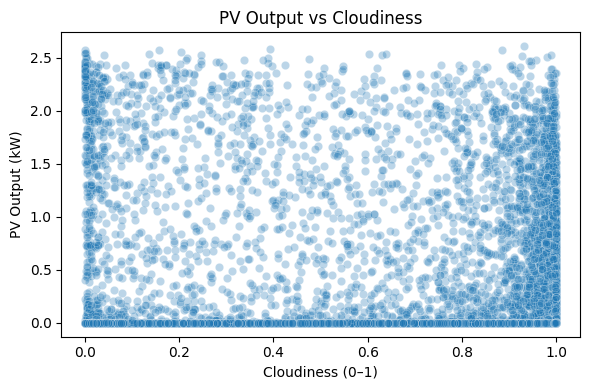

In [23]:
# Scatter: PV Output vs Cloudiness
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_merged, x="cloudiness", y="pv_output_kw", alpha=0.3)
plt.title("PV Output vs Cloudiness")
plt.xlabel("Cloudiness (0–1)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

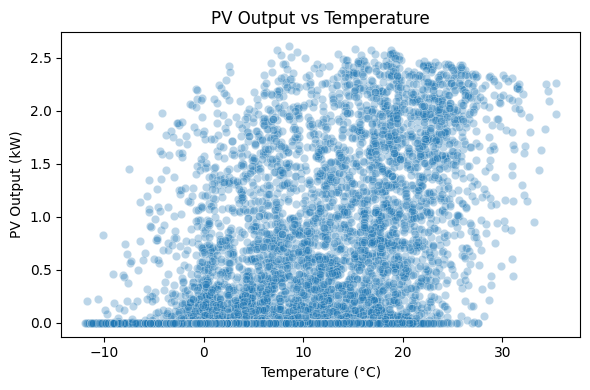

In [24]:
# Scatter: PV Output vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_merged, x="temperature_wx", y="pv_output_kw", alpha=0.3)
plt.title("PV Output vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

In [25]:
# Create bins for cloudiness and temperature
df_merged["cloudiness_bin"] = pd.cut(df_merged["cloudiness"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
df_merged["temperature_bin"] = pd.cut(df_merged["temperature_wx"], bins=6)

In [26]:
df_merged

,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,wind_speed,wind_direction,mean_sea_level_pressure,cloudiness,cloudiness_bin,temperature_bin
time,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,1.38,268.3,95.88,0.5029,"(0.4, 0.6]","(-4.043, 3.853]"
2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,1.36,262.4,95.87,0.6432,"(0.6, 0.8]","(-4.043, 3.853]"
2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,1.42,254.5,95.84,1.0000,"(0.8, 1.0]","(-4.043, 3.853]"
2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,1.45,249.4,95.78,1.0000,"(0.8, 1.0]","(-4.043, 3.853]"
2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,1.47,246.4,95.70,1.0000,"(0.8, 1.0]","(-4.043, 3.853]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,0.0,0.0,0.0,-0.512,19,12,Winter,-0.18,90.85,0.46,42.4,96.06,0.9091,"(0.8, 1.0]","(-4.043, 3.853]"
2019-12-31 20:00:00+00:00,0.0,0.0,0.0,-0.820,20,12,Winter,-0.48,92.38,0.52,90.0,96.10,0.8557,"(0.8, 1.0]","(-4.043, 3.853]"
2019-12-31 21:00:00+00:00,0.0,0.0,0.0,-0.993,21,12,Winter,-0.78,93.07,0.63,135.6,96.07,0.9048,"(0.8, 1.0]","(-4.043, 3.853]"


/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_86119/1663319692.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x="cloudiness_bin", y="pv_output_kw", palette="Blues")


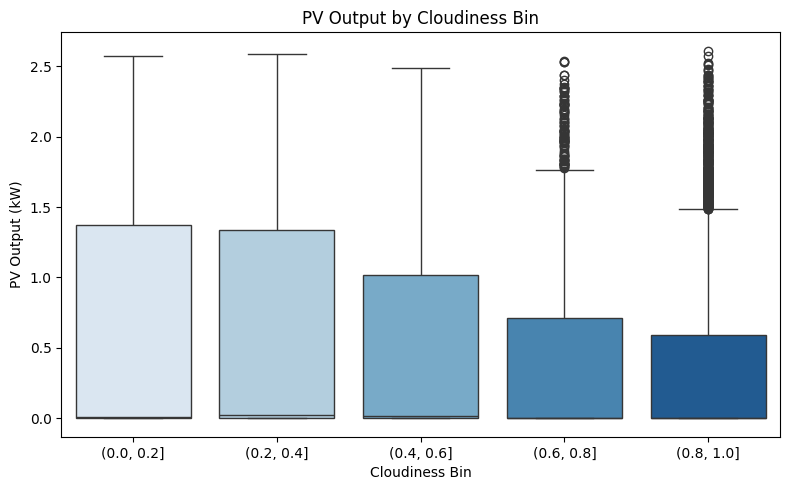

In [27]:
# Boxplot: PV Output by Cloudiness Bin
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x="cloudiness_bin", y="pv_output_kw", palette="Blues")
plt.title("PV Output by Cloudiness Bin")
plt.xlabel("Cloudiness Bin")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()